In [1]:
%matplotlib inline
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
print('Using PyTorch v', torch.__version__)

Using PyTorch v 1.1.0


# Adversarial Example Generation using PyTorch
Demonstrates use of 2 techniques FGSM and PGD.<br>

**References :**

FGSM : Fast Gradient Sign Method <br>
Paper : https://arxiv.org/abs/1412.6572<br>
<br>
PGD : Projected Gradient Descent (Madry et al. 2017)<br>
Paper :  https://arxiv.org/abs/1706.06083<br>
Implementation: https://github.com/MadryLab/mnist_challenge/blob/master/pgd_attack.py<br>

## Training the basic model for attack

Preparing dataset and training a candidate model for attack

In [0]:
## Loading the MNIST dataset
dataset_transform = transforms.Compose([transforms.ToTensor(), \
                                        transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root='./mnist', \
                        download=True, train=True, transform=dataset_transform)
test_set = torchvision.datasets.MNIST(root='./mnist', \
                        download=True, train=False, transform=dataset_transform)

In [0]:
## Preparing samplers for data loading
from torch.utils.data.sampler import SubsetRandomSampler
n_train = 55000
n_val = 5000
n_test = 10000

train_sampler = SubsetRandomSampler(np.arange(n_train, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_train, n_train + n_val,\
                                            dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test, dtype=np.int64))

In [0]:
## Model Definition
from torch.autograd import Variable
import torch.nn
import torch.nn.functional as F

class Network(torch.nn.Module):
  # Batch shape for input x is (1, 28, 28)
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5)
    self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=5)
    self.fc1 = torch.nn.Linear(64*3*3, 256)
    self.fc2 = torch.nn.Linear(256, 10)
    """
    self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    self.fc1 = torch.nn.Linear(32 * 7 * 7, 512)
    
    self.fc2 = torch.nn.Linear(512, 64)
    
    self.fc3 = torch.nn.Linear(64, 10)
    """
    
  def forward(self, x):
    """
    # Pass x through the neural network with appropriate activations
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    
    # Convolution to Fully Connected Transformation
    x = x.view(-1, 32 * 7 * 7)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x), dim=1)
    """
    x = F.relu(self.conv1(x))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = F.dropout(x, p=0.5, training=self.training)
    x = F.relu(F.max_pool2d(self.conv3(x), 2))
    x = F.dropout(x, p=0.5, training=self.training)
    x = x.view(-1, 64*3*3)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)
    

In [0]:
## Function to get all data loaders at one place
def get_data_loaders(batch_size):
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,\
                                            sampler=train_sampler,num_workers=2)
  val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,\
                                          sampler=val_sampler, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, \
                                           sampler=test_sampler, num_workers=2)
  return train_loader, val_loader, test_loader

In [0]:
import torch.optim as optim
# Training Loop
import time
def train(net, device, batch_size, n_epochs, learning_rate):
  # Printing the hyperparameters of the training iterations
  print('-'*64)
  print('Hyperparameters:')
  print('-'*64)
  print('batch_size = ' + str(batch_size))
  print('learning_rate = ' + str(learning_rate))
  print('n_epochs = ' + str(n_epochs))
  print('-'*64)
  
  train_loader, val_loader, test_loader = get_data_loaders(batch_size)
  n_batches = len(train_loader)
  
  loss = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)
  
  train_start_time = time.time()
  for epoch in range(n_epochs):
    
    running_loss = 0.0
    print_every = n_batches // 10
    start_time = time.time()
    total_train_loss = 0
    
    for i, data in enumerate(train_loader, 0):
      # Getting the data and converting them into PyTorch Variables
      inputs, labels = data
      inputs, labels = Variable(inputs), Variable(labels)
      inputs, labels = inputs.to(device), labels.to(device)
      # Setting the parameter gradients to zero
      optimizer.zero_grad()
      
      # Forward pass
      outputs = net(inputs)
      # Compute the loss
      outputs = outputs.to(device)
      loss_size = loss(outputs, labels)
      # Backprop
      loss_size.backward()
      optimizer.step()
      
      # Print stuff
      #running_loss += loss_size.data[0]
      running_loss += loss_size.item()
      total_train_loss += loss_size.item()
      #total_train_loss += loss_size.data[0]
      
      # Print stuff every 10 batches
      if (i+1)%(print_every+1) == 0:
        print('epoch {}, {:d}% \t train_loss: {:.5f} \t took {:.2f}s'.format(\
              epoch+1, int(100*(i+1)/n_batches), running_loss/print_every, \
                                                     time.time() - start_time))
        running_loss = 0.0
        start_time = time.time()
    
    # End of Epoch
    # Begin Validation
    total_val_loss = 0
    for inputs, labels in val_loader:
      # Converting to PyTorchVariables
      inputs, labels = Variable(inputs), Variable(labels)
      inputs, labels = inputs.to(device), labels.to(device)
      val_outputs = net(inputs)
      val_outputs = val_outputs.to(device)
      val_loss_size = loss(val_outputs, labels)
      #total_val_loss += val_loss_size.data[0]
      total_val_loss += val_loss_size.item()
    print('Validation loss = {:.5f}'.format(total_val_loss/len(val_loader)))
    print(32*'-')
    # End of Validation
    
  # End of Training
  print('Training finished, took {:.5f}s'.format(time.time()-train_start_time))
      

In [7]:
print('CUDA Available: ', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network().to(device)
train(model, device, batch_size=32, n_epochs=16, learning_rate=0.001)

CUDA Available:  True
----------------------------------------------------------------
Hyperparameters:
----------------------------------------------------------------
batch_size = 32
learning_rate = 0.001
n_epochs = 16
----------------------------------------------------------------
epoch 1, 10% 	 train_loss: 0.88802 	 took 1.46s
epoch 1, 20% 	 train_loss: 0.29886 	 took 1.36s
epoch 1, 30% 	 train_loss: 0.21091 	 took 1.35s
epoch 1, 40% 	 train_loss: 0.16307 	 took 1.32s
epoch 1, 50% 	 train_loss: 0.16945 	 took 1.34s
epoch 1, 60% 	 train_loss: 0.18017 	 took 1.35s
epoch 1, 70% 	 train_loss: 0.14937 	 took 1.31s
epoch 1, 80% 	 train_loss: 0.13852 	 took 1.60s
epoch 1, 90% 	 train_loss: 0.11900 	 took 1.63s
Validation loss = 0.09386
--------------------------------
epoch 2, 10% 	 train_loss: 0.11841 	 took 1.70s
epoch 2, 20% 	 train_loss: 0.12154 	 took 1.61s
epoch 2, 30% 	 train_loss: 0.11680 	 took 1.48s
epoch 2, 40% 	 train_loss: 0.10915 	 took 1.37s
epoch 2, 50% 	 train_loss: 0.10

## Fast Gradient Sign Method
As explained in the paper, perturbation is created as follows:

$$
X^{adv} = X + \epsilon . sign(\nabla_XJ(X, Y_{true}))
$$
Here,
$X^{adv}$ is the adversarial image created, $X$ is the clean image, $\epsilon$ is the magnitude of adversarial perturbation and $\nabla_XJ(X, Y_{true})$ is the loss function.

### Attack implementation and testing

In [0]:
def fgsm_attack(image, epsilon, data_grad):
  # Getting element-wise sign of the data gradient
  sign = data_grad.sign()
  # Creating the perturbed image
  perturbed_image = image + epsilon*sign
  # Clipping the perturbed image 
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
  return perturbed_image

In [0]:
def test_fgsm_attack(model, device, data_loader, epsilon):
  # Counting the accuracy
  correct_samples = 0
  adversarial_samples = []
  max_adversarial_samples = 5
  # Looping over all samples in data
  for data, target in data_loader:
    # If using CUDA, copy to CUDA device
    data, target = data.to(device), target.to(device)
    # Enables computation of gradient of image itself
    # Setting this will compute the gradient during backprop
    data.requires_grad = True
    # Forward Pass
    output = model(data)
    # Getting the index of max log probability
    # If max log probability at index 5, class 5 has been predicted
    initial_pred = output.max(1, keepdim=True)[1]
    
    if initial_pred.item() != target.item():
      continue # Don't attack if prediction is incorrect
    
    loss = F.nll_loss(output, target)
    model.zero_grad() # Zeoring out all existing gradients for new gradient calc
    loss.backward()
    
    # Collecting data gradient
    data_grad = data.grad.data
    
    # Attack !
    perturbed_data = fgsm_attack(data, epsilon, data_grad)
    
    # Classify the perturbed image
    output = model(perturbed_data)
    
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct_samples += 1
      # Epsilon = 0 is a special case
      if(epsilon == 0) and len(adversarial_samples) < max_adversarial_samples:
        adversarial_sample = perturbed_data.squeeze().detach().cpu().numpy()
        adversarial_samples.append((initial_pred.item(), final_pred.item(), \
                                    adversarial_sample))
    else:
      # If we have room for more addversarial samples
      if(len(adversarial_samples) < max_adversarial_samples):
        adversarial_sample = perturbed_data.squeeze().detach().cpu().numpy()
        adversarial_samples.append((initial_pred.item(), final_pred.item(), \
                                    adversarial_sample))
  # End of loop
  final_acc = correct_samples/float(len(data_loader))
  return final_acc, adversarial_samples

In [10]:
train_loader, val_loader, test_loader = get_data_loaders(1)

accuracies = []
adversarial_samples = []
print('CUDA Available: ', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = Network().to(device)
epsilons = [0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4]
#epsilons = [0.3]
for epsilon in epsilons:
  acc, adv_examples = test_fgsm_attack(model, device, test_loader, epsilon)
  print('Final Accuracy: {:.5f}, epsilon = {:.2f}'.format(acc, epsilon))
  accuracies.append(acc)
  adversarial_samples.append(adv_examples)

CUDA Available:  True
Final Accuracy: 0.61560, epsilon = 0.00
Final Accuracy: 0.54830, epsilon = 0.04
Final Accuracy: 0.46530, epsilon = 0.08
Final Accuracy: 0.38670, epsilon = 0.12
Final Accuracy: 0.32530, epsilon = 0.16
Final Accuracy: 0.27420, epsilon = 0.20
Final Accuracy: 0.23440, epsilon = 0.24
Final Accuracy: 0.20340, epsilon = 0.28
Final Accuracy: 0.18660, epsilon = 0.32
Final Accuracy: 0.17320, epsilon = 0.36
Final Accuracy: 0.16740, epsilon = 0.40


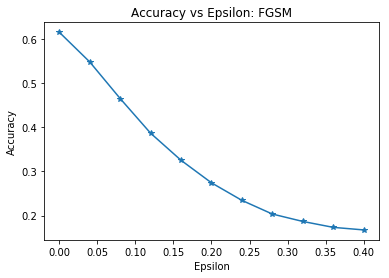

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epsilons, accuracies, '*-')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon: FGSM')
plt.show()

### Visualizations of adversarial samples generated

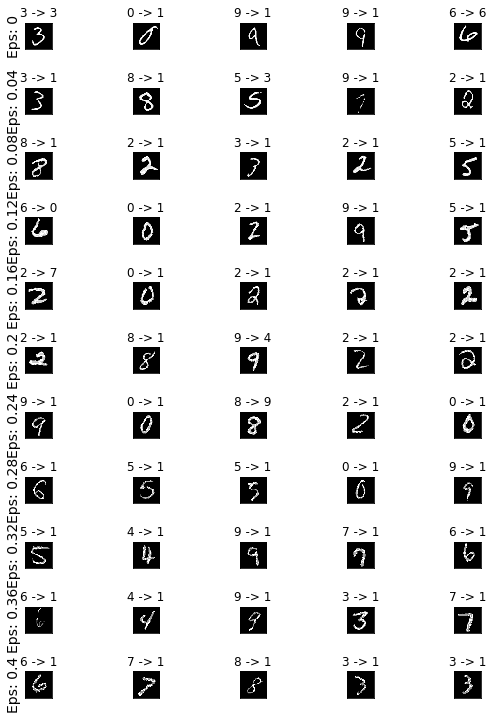

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
examples = adversarial_samples
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Projected Gradient Descent
While the FGSM is a good approximation for linearization of the loss function, projected gradient descent clips the perturbation to trap it inside the $L_\infty$ sphere. Other norms are also possible to use.

In [0]:
def pgd_attack(image, epsilon, data_grad):
  # Getting element-wise sign of the data gradient
  sign = data_grad.sign()
  # Creating the perturbed image
  perturbed_image = image + epsilon*sign
  # Projecting perturbation within the `epsilon` sphere
  # 2 ways of doing this
  # Either use np.clip(perturbed_image, image+/-epsilon) or the following
  perturbed_image = torch.where(perturbed_image > image + epsilon, \
                               image + epsilon, perturbed_image)
  perturbed_image = torch.where(perturbed_image < image - epsilon, \
                               image - epsilon, perturbed_image)
  # Clipping the perturbed image 
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
  return perturbed_image

In [0]:
def test_pgd_attack(model, device, data_loader, epsilon):
  # Counting the accuracy
  correct_samples = 0
  adversarial_samples = []
  max_adversarial_samples = 5
  # Looping over all samples in data
  for data, target in data_loader:
    # If using CUDA, copy to CUDA device
    data, target = data.to(device), target.to(device)
    # Enables computation of gradient of image itself
    # Setting this will compute the gradient during backprop
    data.requires_grad = True
    # Forward Pass
    output = model(data)
    # Getting the index of max log probability
    # If max log probability at index 5, class 5 has been predicted
    initial_pred = output.max(1, keepdim=True)[1]
    
    if initial_pred.item() != target.item():
      continue # Don't attack if prediction is incorrect
    
    loss = F.nll_loss(output, target)
    model.zero_grad() # Zeoring out all existing gradients for new gradient calc
    loss.backward()
    
    # Collecting data gradient
    data_grad = data.grad.data
    
    # Attack !
    perturbed_data = pgd_attack(data, epsilon, data_grad)
    
    # Classify the perturbed image
    output = model(perturbed_data)
    
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct_samples += 1
      # Epsilon = 0 is a special case
      if(epsilon == 0) and len(adversarial_samples) < max_adversarial_samples:
        adversarial_sample = perturbed_data.squeeze().detach().cpu().numpy()
        adversarial_samples.append((initial_pred.item(), final_pred.item(), \
                                    adversarial_sample))
    else:
      # If we have room for more addversarial samples
      if(len(adversarial_samples) < max_adversarial_samples):
        adversarial_sample = perturbed_data.squeeze().detach().cpu().numpy()
        adversarial_samples.append((initial_pred.item(), final_pred.item(), \
                                    adversarial_sample))
  # End of loop
  final_acc = correct_samples/float(len(data_loader))
  return final_acc, adversarial_samples

In [15]:
train_loader, val_loader, test_loader = get_data_loaders(1)

accuracies = []
adversarial_samples = []
print('CUDA Available: ', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = Network().to(device)
epsilons = [0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4]

for epsilon in epsilons:
  acc, adv_examples = test_pgd_attack(model, device, test_loader, epsilon)
  print('Final Accuracy: {:.5f}, epsilon = {:.2f}'.format(acc, epsilon))
  accuracies.append(acc)
  adversarial_samples.append(adv_examples)

CUDA Available:  True
Final Accuracy: 0.62010, epsilon = 0.00
Final Accuracy: 0.55480, epsilon = 0.04
Final Accuracy: 0.46570, epsilon = 0.08
Final Accuracy: 0.38470, epsilon = 0.12
Final Accuracy: 0.32560, epsilon = 0.16
Final Accuracy: 0.26960, epsilon = 0.20
Final Accuracy: 0.23300, epsilon = 0.24
Final Accuracy: 0.20950, epsilon = 0.28
Final Accuracy: 0.18580, epsilon = 0.32
Final Accuracy: 0.17530, epsilon = 0.36
Final Accuracy: 0.16440, epsilon = 0.40


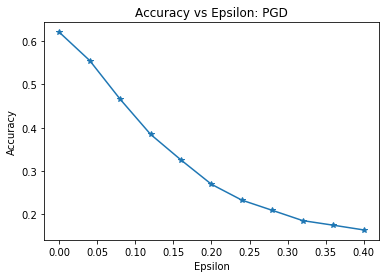

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epsilons, accuracies, '*-')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon: PGD')
plt.show()

### Visualizations of adversarial samples generated

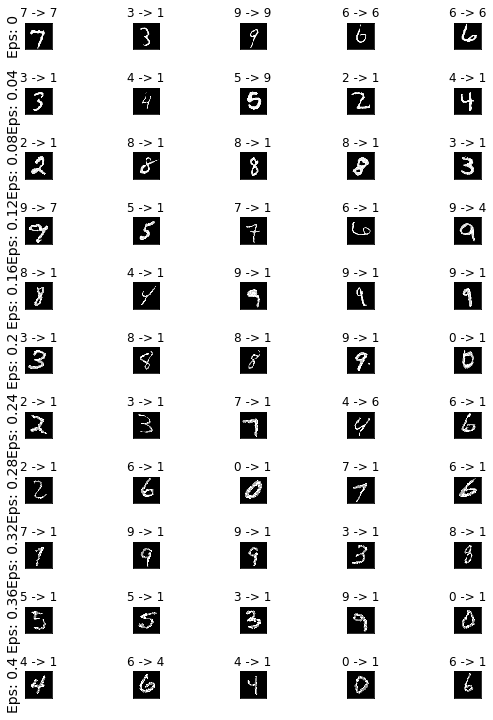

In [17]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
examples = adversarial_samples
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()



In [18]:
"""
## TODO:
In functions `fgsm_attack` and `pgd_attack`, take `loss` and `model` as argument
instead of `data_grad` directly.
Also make sure to zero the gradient before adding it to the `image`
"""

'\n## TODO:\nIn functions `fgsm_attack` and `pgd_attack`, take `loss` and `model` as argument\ninstead of `data_grad` directly.\nAlso make sure to zero the gradient before adding it to the `image`\n'